<a href="https://colab.research.google.com/github/infomon/understanding_cnn/blob/master/notebooks/Bottleneck_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install numba
!pip install umap-learn
!pip install wget

In [33]:
!git clone https://github.com/infomon/understanding_cnn
  
import shutil
import os
if not os.path.isfile("utils.py"):
  shutil.move("/content/understanding_cnn/utils/utils.py", "/content")
if not os.path.isfile("utils_imagenet.py"):
  shutil.move("/content/understanding_cnn/utils/utils_imagenet.py", "/content")
if not os.path.isdir("models"):
  shutil.move("/content/understanding_cnn/models", "/content")
if not os.path.isdir("images"):
  shutil.move("/content/understanding_cnn/data/images", "/content")
if not os.path.isfile("data_loader.py"):
  shutil.move("/content/understanding_cnn/data/data_loader.py", "/content")
  
!rm -r understanding_cnn

Cloning into 'understanding_cnn'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 178 (delta 79), reused 86 (delta 19), pack-reused 0
Receiving objects: 100% (178/178), 15.43 MiB | 18.31 MiB/s, done.
Resolving deltas: 100% (79/79), done.


# Extract Bottleneck Features for Train Set

In [8]:
import models.model_loader as model_loader
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input

# load model + remove final classification layers

model_tmp = model_loader.Resnet_v1_101(include_top=False)
model = model_tmp.get_model()

#model = VGG19(weights='imagenet', include_top=False, input_shape=(139, 139, 3))

W0329 10:46:59.952578 140021580187520 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


Instructions for updating:
Colocations handled automatically by placer.


W0329 10:47:00.028757 140021580187520 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [0]:
from keras.datasets import cifar10
import numpy as np

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = np.squeeze(y_train)

nof_images = 7000
x_train = x_train[7*nof_images:50000]

In [10]:
import keras
import numpy as np
import scipy
from scipy import misc
import os
import cv2

# obtain bottleneck features (train)
if os.path.exists('features_train_.npz'):
    print('bottleneck features detected (train)')
    features = np.load('features_train_.npz')['features']
else:
    print('calculating now ...')
    # pre-process the train data
    tmp = []
    for i in range(0,len(x_train)):
      tmp.append(cv2.resize(x_train[i], (139, 139)))
      
    big_x_train = np.array(tmp).astype('float32') 
    model_input_train = model_tmp.preprocess_input(big_x_train)
    #model_input_train = preprocess_input(big_x_train)
    
    # extract, process, and save bottleneck features
    features = model.predict(model_input_train)
    features = np.squeeze(features)
    np.savez('features_train_8', features=features)
    print('bottleneck features saved (train)')

calculating now ...
bottleneck features saved (train)


# Plot UMAP Embedding of Bottleneck Features for Train Set

In [11]:
import umap

# reshape bottleneck features + reduce dimensionality with t-SNE
if os.path.exists('umap_features.npz'):
    umap_features = np.load('umap_features.npz')['umap_features']
else:
    print('calculating now ...')
    umap_features = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(np.reshape(features,(features.shape[0],np.prod(features.shape[1:]))))
    np.savez('umap_features_8', umap_features=umap_features)
print('umap features saved')


calculating now ...
umap features saved


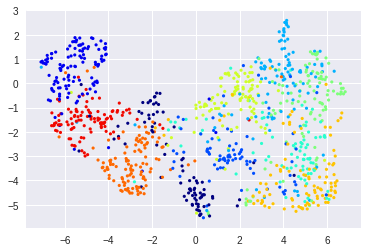

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the features
plt.figure()
sc = plt.scatter(umap_features[:,0], umap_features[:,1], c=plt.cm.jet(y_train[49000:50000]/10), s=10, edgecolors='none')
#plt.colorbar(sc)
plt.show()